In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from scipy.misc import imresize
from skimage import io

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.


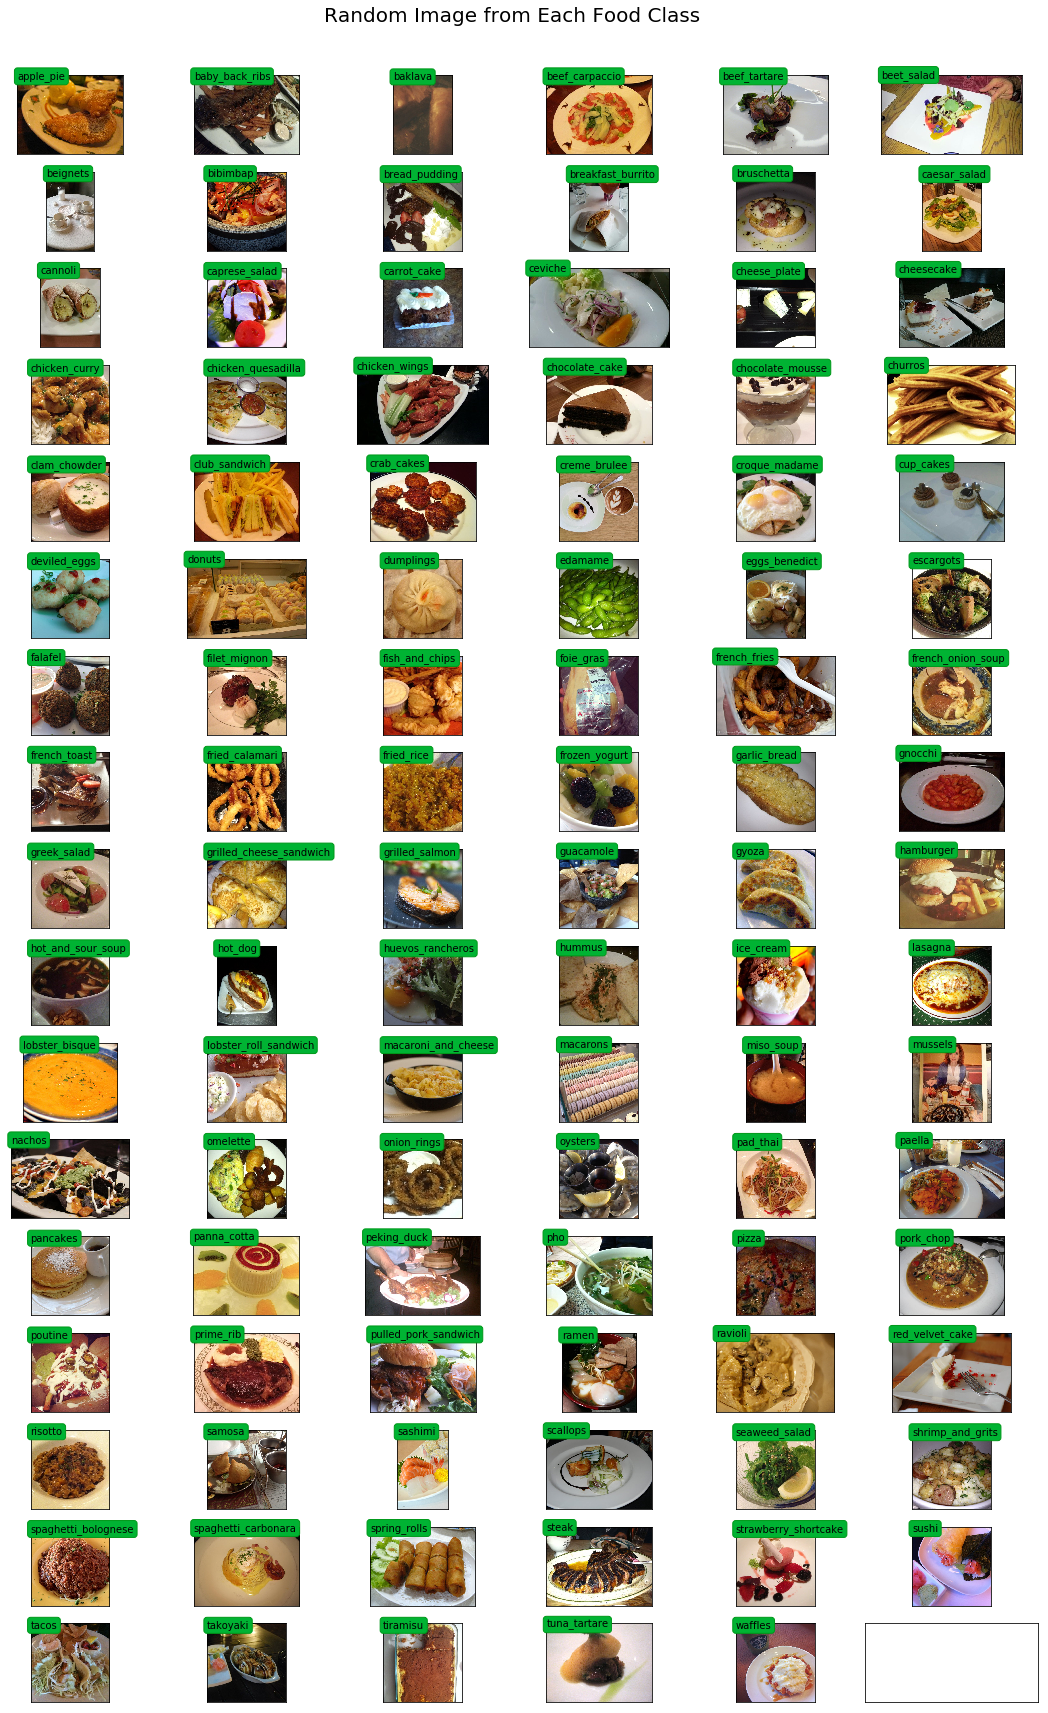

In [2]:
#  Look at some random images from each food class.
root_dir = 'food41/images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [3]:
# Setup multiprocessing pool to accelerate image augmentation during trainin
# Do this early, as once images are loaded into memory there will be Errno 12
# http://stackoverflow.com/questions/14749897/python-multiprocessing-memory-usage
import multiprocessing as mp

num_processes = 2
pool = mp.Pool(processes=num_processes)

In [4]:
# Map from class to index and vice versa, for proper label encoding and pretty printing.
class_to_ix = {}
ix_to_class = {}
with open('food41/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [5]:
# The Food-101 dataset has a provided train/test split. We want to use this in order to compare our classifcation 
# performance with other implementations.
# Only split files if haven't already
if not os.path.isdir('./food41/test') and not os.path.isdir('./food41/train'):
    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('food41/meta/train.txt')
    test_dir_files = generate_dir_file_map('food41/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food41/images', 'food41/test', ignore=ignore_train)
    copytree('food41/images', 'food41/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

Train/Test files already copied into separate folders.


In [6]:
# Load part of dataset images (since I do not have enough memory) and resize to meet minimum width and height pixel size
def load_images(root, img_num_limit, min_side=299):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = class_to_ix[subdir]
        print(i, class_ix, subdir)
        img_count = 0
        for img_name in imgs:
            img_count = img_count + 1
            if img_count > img_num_limit:
                break
            
            # img_arr = img.imread(join(root, subdir, img_name))
            img_arr = io.imread(join(root, subdir, img_name))
            img_arr_rs = img_arr
            try:
                w, h, _ = img_arr.shape
                if w < min_side:
                    wpercent = (min_side/float(w))
                    hsize = int((float(h)*float(wpercent)))
                    #print('new dims:', min_side, hsize)
                    img_arr_rs = imresize(img_arr, (min_side, hsize))
                    resize_count += 1
                elif h < min_side:
                    hpercent = (min_side/float(h))
                    wsize = int((float(w)*float(hpercent)))
                    #print('new dims:', wsize, min_side)
                    img_arr_rs = imresize(img_arr, (wsize, min_side))
                    resize_count += 1
                all_imgs.append(img_arr_rs)
                all_classes.append(class_ix)
            except:
                print('Skipping bad image: ', subdir, img_name)
                invalid_count += 1
    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)

In [7]:
# Set the image number limit of each class to 2
X_test, y_test = load_images('food41/test', 2, min_side=299)

0 0 apple_pie
1 1 baby_back_ribs
2 2 baklava
3 3 beef_carpaccio
4 4 beef_tartare
5 5 beet_salad
6 6 beignets
7 7 bibimbap
8 8 bread_pudding
9 9 breakfast_burrito
10 10 bruschetta
11 11 caesar_salad
12 12 cannoli
13 13 caprese_salad
14 14 carrot_cake
15 15 ceviche
16 16 cheesecake
17

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 17 cheese_plate
18 18 chicken_curry
19 19 chicken_quesadilla
20 20 chicken_wings
21 21 chocolate_cake
22 22 chocolate_mousse
23 23 churros
24 24 clam_chowder
25 25 club_sandwich
26 26 crab_cakes
27 27 creme_brulee
28 28 croque_madame
29 29 cup_cakes
30 30 deviled_eggs
31 31 donuts
32 32 dumplings
33 33 edamame
34 34 eggs_benedict
35 35 escargots
36 36 falafel
37 37 filet_mignon
38 38 fish_and_chips
39 39 foie_gras
40 40 french_fries
41 41 french_onion_soup
42 42 french_toast
43 43 fried_calamari
44 44 fried_rice
45 45 frozen_yogurt
46 46 garlic_bread
47 47 gnocchi
48 48 greek_salad
49 49 grilled_cheese_sandwich
50 50 grilled_salmon
51 51 guacamole
52 52 gyoza
53 53 hamburger
54 54 hot_and_sour_soup
55 55 hot_dog
56 56 huevos_rancheros
57 57 hummus
58 58 ice_cream
59 59 lasagna
60 60 lobster_bisque
61 61 lobster_roll_sandwich
62 62 macaroni_and_cheese
63 63 macarons
64 64 miso_soup
65 65 mussels
66 66 nachos
67 67 omelette
68 68 onion_rings
69 69 oysters
70 70 pad_thai
71 71 paella
72 

In [8]:
%%time
# Set the image number limit of each class to 10
X_train, y_train = load_images('food41/train', 10, min_side=299)

0 0 apple_pie
1 1 baby_back_ribs
2 2 baklava
3 3 beef_carpaccio
4 4 beef_tartare
5 5 beet_salad
6 6 beignets
7 7 bibimbap
8 8 bread_pudding
9 9 breakfast_burrito
10 10 bruschetta
11 11 caesar_salad
12 12 cannoli
13 13 caprese_salad
14 14 carrot_cake
15 15 ceviche
16 16 cheesecake
17 17 cheese_plate
18 18 chicken_curry
19 19 chicken_quesadilla
20 20 chicken_wings


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


21 21 chocolate_cake
22 22 chocolate_mousse
23 23 churros
24 24 clam_chowder
25 25 club_sandwich
26 26 crab_cakes
27 27 creme_brulee
28 28 croque_madame
29 29 cup_cakes
30 30 deviled_eggs
31 31 donuts
32 32 dumplings
33 33 edamame
34 34 eggs_benedict
35 35 escargots
36 36 falafel
37 37 filet_mignon
38 38 fish_and_chips
39 39 foie_gras
40 40 french_fries
41 41 french_onion_soup
42 42 french_toast
43 43 fried_calamari
44 44 fried_rice
45 45 frozen_yogurt
46 46 garlic_bread
47 47 gnocchi
48 48 greek_salad
49 49 grilled_cheese_sandwich
50 50 grilled_salmon
51 51 guacamole
52 52 gyoza
53 53 hamburger
54 54 hot_and_sour_soup
55 55 hot_dog
56 56 huevos_rancheros
57 57 hummus
58 58 ice_cream
59 59 lasagna
60 60 lobster_bisque
61 61 lobster_roll_sandwich
62 62 macaroni_and_cheese
63 63 macarons
64 64 miso_soup
65 65 mussels
66 66 nachos
67 67 omelette
68 68 onion_rings
69 69 oysters
70 70 pad_thai
71 71 paella
72 72 pancakes
73 73 panna_cotta
74 74 peking_duck
75 75 pho
76 76 pizza
77 77 pork_c

In [9]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (1010,)
y_train shape (1010,)
X_test shape (202,)
y_test shape (202,)


In [10]:
@interact(n=(0, len(X_train)))
def show_pic(n):
    plt.imshow(X_train[n])
    print('current class:', y_train[n], ix_to_class[y_train[n]])

interactive(children=(IntSlider(value=505, description='n', max=1010), Output()), _dom_classes=('widget-intera…

In [11]:
@interact(n=(0, len(X_test)))
def show_pic(n):
    plt.imshow(X_test[n])
    print('current class:', y_test[n], ix_to_class[y_test[n]])

interactive(children=(IntSlider(value=101, description='n', max=202), Output()), _dom_classes=('widget-interac…

In [12]:
@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    print("class no. of train data: ", n_class)
    nrows = 4
    ncols = 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(12, 8)
    #fig.tight_layout()
    imgs = np.random.choice((y_train == n_class).nonzero()[0], nrows * ncols)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(X_train[imgs[i]])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    plt.show()

interactive(children=(Dropdown(description='n_class', options=OrderedDict([('apple_pie', 0), ('baby_back_ribs'…

In [13]:
@interact(n_class=sorted_class_to_ix)
def show_random_images_of_class(n_class=0):
    print("class no. of test data: ", n_class)
    nrows = 4
    ncols = 8
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches(12, 8)
    #fig.tight_layout()
    imgs = np.random.choice((y_test == n_class).nonzero()[0], nrows * ncols)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(X_test[imgs[i]])
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    plt.show()

interactive(children=(Dropdown(description='n_class', options=OrderedDict([('apple_pie', 0), ('baby_back_ribs'…

In [14]:
from keras.utils.np_utils import to_categorical

n_classes = 101
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

In [15]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input

import tools.image_gen_extended as T

In [16]:
%%time

# this is the augmentation configuration we will use for training
train_datagen = T.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False, # randomly flip images
    zoom_range=[.8, 1],
    channel_shift_range=30,
    fill_mode='reflect')
train_datagen.config['random_crop_size'] = (299, 299)
train_datagen.set_pipeline([T.random_transform, T.random_crop, T.preprocess_input])
train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=64, seed=3, pool=pool)

Wall time: 0 ns


In [17]:
test_datagen = T.ImageDataGenerator()
test_datagen.config['random_crop_size'] = (299, 299)
test_datagen.set_pipeline([T.random_transform, T.random_crop, T.preprocess_input])
test_generator = test_datagen.flow(X_test, y_test_cat, batch_size=64, seed=11, pool=pool)

In [19]:
def reverse_preprocess_input(x0):
    x = x0 / 2.0
    x += 0.5
    x *= 255.
    return x

In [20]:
%%time
@interact()
def show_images(unprocess=True):
    for x in test_generator:
        fig, axes = plt.subplots(nrows=8, ncols=4)
        fig.set_size_inches(8, 8)
        page = 0
        page_size = 32
        start_i = page * page_size
        for i, ax in enumerate(axes.flat):
            img = x[0][i+start_i]
            if unprocess:
                im = ax.imshow( reverse_preprocess_input(img).astype('uint8') )
            else:
                im = ax.imshow(img)
            ax.set_axis_off()
            ax.title.set_visible(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)

        plt.subplots_adjust(left=0, wspace=0, hspace=0)
        plt.show()
        break

interactive(children=(Checkbox(value=True, description='unprocess'), Output()), _dom_classes=('widget-interact…

Wall time: 2.17 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

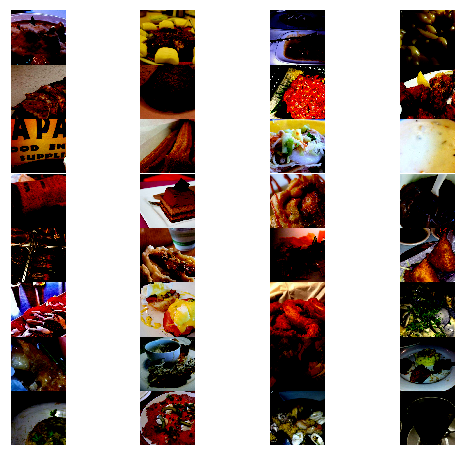

Wall time: 2.02 s


In [21]:
%%time
show_images(unprocess=False)

In [ ]:
%%time
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.regularizers import l2
import keras.backend as K
import math

K.clear_session()

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
x = base_model.output
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Dropout(.4)(x)
x = Flatten()(x)
predictions = Dense(n_classes, init='glorot_uniform', W_regularizer=l2(.0005), activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

opt = SGD(lr=.01, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model4.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model4.log')

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

model.fit_generator(train_generator,
                    validation_data=test_generator,
                    nb_val_samples=X_test.shape[0],
                    samples_per_epoch=X_train.shape[0],
                    nb_epoch=32,
                    verbose=2,
                    callbacks=[lr_scheduler, csv_logger, checkpointer])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(101, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer=<keras.reg...)`
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<tools.ima.

Instructions for updating:
Use tf.cast instead.
Epoch 1/32
 - 3048s - loss: 4.8989 - acc: 0.0146 - val_loss: 4.4502 - val_acc: 0.0739

Epoch 00001: val_loss improved from inf to 4.45019, saving model to model4.01-4.45.hdf5
Epoch 2/32
 - 3009s - loss: 4.3553 - acc: 0.0918 - val_loss: 3.9578 - val_acc: 0.2240

Epoch 00002: val_loss improved from 4.45019 to 3.95784, saving model to model4.02-3.96.hdf5
Epoch 3/32
 - 2992s - loss: 3.6592 - acc: 0.2485 - val_loss: 3.0511 - val_acc: 0.3426

Epoch 00003: val_loss improved from 3.95784 to 3.05107, saving model to model4.03-3.05.hdf5
Epoch 4/32
 - 3005s - loss: 2.9833 - acc: 0.3886 - val_loss: 2.5056 - val_acc: 0.4417

Epoch 00004: val_loss improved from 3.05107 to 2.50561, saving model to model4.04-2.51.hdf5
Epoch 5/32
 - 2991s - loss: 2.3557 - acc: 0.5216 - val_loss: 2.2281 - val_acc: 0.4792

Epoch 00005: val_loss improved from 2.50561 to 2.22807, saving model to model4.05-2.23.hdf5
Epoch 6/32
 - 2999s - loss: 1.8220 - acc: 0.6460 - val_loss: 